# Strategy 1

### Parameters:
* **Lookback window for Levy:** 30 trading days
* **Selection percentiles:** 20% leaders and 20% followers
* **Rebalance/holding horizon:** k = 7 trading days (non-overlapping, same schedule as GP)

---

### Steps:
1.  **Compute daily rolling Levy matrices:**
    * For each day $t$, take the last 30 trading days of prices.
    * Convert to returns, standardize within the window.
    * Build the Levy area matrix $L_t$ (antisymmetric). Keep only positive entries and set diagonal to 0.
    * Score each asset: row-sum of the positive $L_t$.

2.  **Pick leaders & followers for day $t$:**
    * **Leaders** = top 20% by score.
    * **Followers** = bottom 20% by score.

3.  **Form the signal at the GP entry date $t$:**
    * Compute leaders' average raw return on day $t$, call it $\bar{r}_t^L$.
    * If $\bar{r}_t^L > 0 \rightarrow$ we expect followers to do well over the next block.
    * If $\bar{r}_t^L < 0 \rightarrow$ we prefer the broad equal-weighted market.

4.  **Long leg only portfolio over $(t, t + k]$ (no short leg at all):**
    * If $\bar{r}_t^L > 0$: **go long followers** equal-weight each day in $(t, t + k]$.
    * Else: **go long market** (equal-weight across all available assets) each day in $(t, t + k]$.
    * Compound daily returns within the block.
    * Move to the next non-overlapping block.

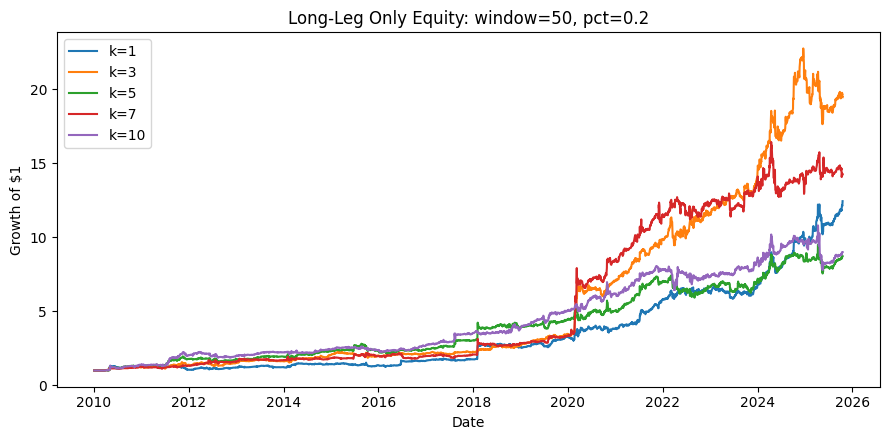

Downloads:
- Significance table: significance_k_5_7_10.csv
- Equity curves: long_leg_only_equities_k_5_7_10.csv


,k,n_followers_long_blocks,mean(F-M),std(F-M),t_stat(≈),95% CI (boot),hit_rate,hit_p(≈),mean_IC,IC_t(≈),IC_CI (boot)
0,1,2008,0.000525,0.015598,1.509101,"[-0.00014, 0.00123]",0.508964,0.434765,0.013539,1.754164,"[-0.00129, 0.02782]"
1,3,678,0.002144,0.025453,2.192976,"[0.00033, 0.00416]",0.519174,0.336995,0.033084,2.396860,"[0.00579, 0.06039]"
2,5,399,0.001629,0.030756,1.058012,"[-0.00110, 0.00486]",0.536341,0.160989,0.020424,1.121563,"[-0.01478, 0.05602]"
3,7,268,0.004669,0.049657,1.539351,"[-0.00059, 0.01136]",0.500000,1.000000,-0.002480,-0.121033,"[-0.04221, 0.03710]"
4,10,208,0.003034,0.038242,1.144353,"[-0.00211, 0.00834]",0.572115,0.044348,0.039613,1.615725,"[-0.01123, 0.08713]"


,AnnReturn,AnnVol,Sharpe,MaxDD
k,,,,
1,0.173330,0.196007,0.884308,-0.247602
3,0.207121,0.174845,1.184597,-0.224800
5,0.147197,0.191062,0.770414,-0.233170
7,0.183488,0.214785,0.854287,-0.226301
10,0.149491,0.166187,0.899534,-0.279229


In [ ]:
# - Reads data
# - Computes Levy matrices correctly (S_t from [t-window, t) with no lookahead)
# - Builds global scores (sum of positive entries by row)
# - Picks leaders/followers by percentile
# - Long-Leg Only backtest (non-overlapping k-day blocks)
# - Significance testing (followers-long blocks):
#     * Mean(Followers_k - Market_k), t-stat (approx), 95% bootstrap CI
#     * Hit rate and normal-approx binomial p-value
#     * Mean Spearman IC between (-score_t) and next-k returns
# - Utility: plot equity for any (k, window, pct)
# - Final: overlay k in {5,7,10} (window=30, pct=0.20) and show significance table for each.


import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


# -------------------------------
# 1) Read and prepare data
# -------------------------------
DATA_PATH = "macro_instruments.csv"
assert os.path.exists(DATA_PATH), "Data file not found."

def load_prices(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Pick a date-like column
    date_col = [c for c in df.columns if c.lower() in ("date","timestamp","time")]
    date_col = date_col[0] if date_col else df.columns[0]
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(by=date_col).set_index(date_col)
    prices = df.select_dtypes(include=[np.number]).replace([np.inf,-np.inf], np.nan)
    prices = prices.dropna(axis=1, how="all").ffill().bfill()
    return prices

prices = load_prices(DATA_PATH)

# Precompute daily returns for later use
all_rets = prices.pct_change()

# -------------------------------
# 2) Levy & scoring utilities
# -------------------------------
def standardized_returns(win: pd.DataFrame) -> pd.DataFrame:
    rets = win.pct_change().dropna()
    return (rets - rets.mean()) / rets.std()

def levy_matrix(std_win: pd.DataFrame) -> pd.DataFrame:
    X = std_win.values
    n = std_win.shape[1]
    if X.shape[0] < 2:
        M = np.zeros((n, n))
    else:
        M1 = X[:-1].T @ X[1:]
        M = 0.5 * (M1 - M1.T)
    L = pd.DataFrame(M, index=std_win.columns, columns=std_win.columns)
    np.fill_diagonal(L.values, 0.0)
    return L

def build_S_by_t(prices: pd.DataFrame, window: int) -> dict:
    """Return dict: entry date t -> Levy matrix from the prior `window` days [t-window, t)."""
    idx = prices.index
    S_by_t = {}
    for i in range(window, len(idx)):
        t = idx[i]
        win = prices.iloc[i-window:i, :].dropna(axis=1)
        if win.shape[1] == 0:
            continue
        std_win = standardized_returns(win)
        L = levy_matrix(std_win)
        S_by_t[t] = L
    return S_by_t

def global_scores_from_S(S_by_t: dict) -> pd.DataFrame:
    """Row-sum of positive Levy entries; rows indexed by t, columns by asset."""
    rows = []
    for t, S in S_by_t.items():
        Spos = S.where(S > 0.0, 0.0)
        sc = Spos.sum(axis=1)
        rows.append(pd.DataFrame({t: sc}).T)
    if len(rows) == 0:
        return pd.DataFrame()
    return pd.concat(rows).sort_index()

def leaders_followers(scores_t: pd.Series, pct: float) -> tuple[list, list]:
    non_nan = scores_t.dropna()
    n = len(non_nan)
    k = max(1, int(np.floor(pct * n)))
    followers = non_nan.nsmallest(k).index.tolist()
    leaders = non_nan.nlargest(k).index.tolist()
    return followers, leaders

def build_gp_lf(global_scores: pd.DataFrame, pct: float) -> pd.Series:
    return global_scores.apply(lambda row: leaders_followers(row, pct), axis=1)

# -------------------------------
# 3) Long-Leg Only backtest
# -------------------------------
def long_leg_only_daily(prices: pd.DataFrame, rets: pd.DataFrame, gp_lf: pd.Series, k: int) -> pd.Series:
    """Daily returns time series under non-overlapping k-day blocks:
       If leaders' day-t mean return > 0 -> long followers over (t, t+k]
       Else -> long equal-weight market over (t, t+k]."""
    times = gp_lf.index.intersection(rets.index).sort_values()
    daily = []
    for i in range(0, len(times) - k, k):
        t, t1 = times[i], times[i + k]
        followers, leaders = gp_lf.loc[t]
        followers = [a for a in followers if a in rets.columns]
        leaders   = [a for a in leaders   if a in rets.columns]
        if not followers or not leaders:
            continue

        LRet = rets.loc[t, leaders].mean()

        slab = rets.loc[(rets.index > t) & (rets.index <= t1)]
        if slab.empty:
            continue

        for dt, r in slab.iterrows():
            avail = r.dropna()
            U = avail.index.tolist()
            F = [a for a in followers if a in U]
            if len(U) == 0:
                continue
            if LRet > 0 and len(F) > 0:
                w = pd.Series(0.0, index=U); w.loc[F] = 1.0 / len(F)
            else:
                w = pd.Series(1.0 / len(U), index=U)
            daily.append((dt, float((w * avail).sum())))

    if not daily:
        return pd.Series(dtype=float, name="ret")
    out = pd.DataFrame(daily, columns=["date", "ret"]).set_index("date").sort_index()["ret"]
    return out

def perf_summary(daily_ret: pd.Series) -> dict:
    daily_ret = daily_ret.dropna()
    if len(daily_ret) == 0:
        return {"AnnReturn": np.nan, "AnnVol": np.nan, "Sharpe": np.nan, "MaxDD": np.nan}
    equity = (1.0 + daily_ret).cumprod()
    ann_ret = equity.iloc[-1] ** (252 / len(equity)) - 1
    ann_vol = daily_ret.std(ddof=0) * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol and not np.isnan(ann_vol) and ann_vol != 0 else np.nan
    mdd = ((equity / equity.cummax()) - 1).min()
    return {"AnnReturn": ann_ret, "AnnVol": ann_vol, "Sharpe": sharpe, "MaxDD": mdd}

# -------------------------------
# 4) Significance tests (followers identification)
# -------------------------------
def spearman_corr(x: pd.Series, y: pd.Series) -> float:
    X = x.rank()
    Y = y.rank()
    X, Y = X.align(Y, join="inner")
    if len(X) < 3:
        return np.nan
    # Pearson on ranks
    return np.corrcoef(X.values, Y.values)[0, 1]

def bootstrap_ci_mean(x: np.ndarray, n_boot: int = 2000, alpha: float = 0.05, seed: int = 42) -> tuple[float, float]:
    rng = np.random.default_rng(seed)
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    if len(x) == 0:
        return (np.nan, np.nan)
    means = []
    for _ in range(n_boot):
        samp = rng.choice(x, size=len(x), replace=True)
        means.append(np.mean(samp))
    lo = np.quantile(means, alpha/2)
    hi = np.quantile(means, 1-alpha/2)
    return float(lo), float(hi)

def normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def significance_table(prices: pd.DataFrame, rets: pd.DataFrame, global_scores: pd.DataFrame, gp_lf: pd.Series, k: int) -> pd.DataFrame:
    times = gp_lf.index.intersection(rets.index).sort_values()

    diffs = []   # FRet_k - MktRet_k on followers-long blocks
    ics = []     # Spearman IC on followers-long blocks

    for i in range(0, len(times) - k, k):
        t, t1 = times[i], times[i + k]
        followers, leaders = gp_lf.loc[t]
        followers = [a for a in followers if a in rets.columns]
        leaders   = [a for a in leaders   if a in rets.columns]
        if not followers or not leaders:
            continue

        LRet = rets.loc[t, leaders].mean()
        slab = rets.loc[(rets.index > t) & (rets.index <= t1)]
        if slab.empty:
            continue

        # k-day compounded returns
        FRet = (1.0 + slab[followers].mean(axis=1, skipna=True).dropna()).prod() - 1.0
        MktRet = (1.0 + slab.mean(axis=1, skipna=True).dropna()).prod() - 1.0

        # Only evaluate follower identification when we actually long followers
        if LRet > 0:
            diffs.append(FRet - MktRet)

            # Per-asset k-day returns for IC
            per_asset = (1.0 + slab).prod() - 1.0
            s_t = global_scores.loc[t].dropna()
            s_t, per_asset = s_t.align(per_asset, join="inner")
            ic = spearman_corr(-s_t, per_asset)  # followers = lower score -> expect higher future return
            ics.append(ic)

    # Aggregate stats
    d = np.array(diffs, dtype=float)
    n = int(np.sum(~np.isnan(d)))
    d_mean = float(np.nanmean(d)) if n else np.nan
    d_std = float(np.nanstd(d, ddof=1)) if n > 1 else np.nan
    t_stat = d_mean / (d_std / np.sqrt(n)) if (n > 1 and d_std > 0) else np.nan
    ci_lo, ci_hi = bootstrap_ci_mean(d, n_boot=2000, alpha=0.05)

    hits = int(np.sum(d > 0))
    p0 = 0.5
    z = (hits - n*p0 - 0.5*np.sign(hits - n*p0)) / math.sqrt(max(n*p0*(1-p0), 1e-12)) if n > 0 else np.nan
    p_binom = 2 * (1 - normal_cdf(abs(z))) if n > 0 else np.nan

    ic_arr = np.array(ics, dtype=float)
    m = int(np.sum(~np.isnan(ic_arr)))
    ic_mean = float(np.nanmean(ic_arr)) if m else np.nan
    ic_std = float(np.nanstd(ic_arr, ddof=1)) if m > 1 else np.nan
    ic_t = ic_mean / (ic_std / np.sqrt(m)) if (m > 1 and ic_std > 0) else np.nan
    ic_lo, ic_hi = bootstrap_ci_mean(ic_arr, n_boot=2000, alpha=0.05)

    row = {
        "k": k,
        "n_followers_long_blocks": n,
        "mean(F-M)": d_mean,
        "std(F-M)": d_std,
        "t_stat(≈)": t_stat,
        "95% CI (boot)": f"[{ci_lo:.5f}, {ci_hi:.5f}]",
        "hit_rate": (hits / n) if n else np.nan,
        "hit_p(≈)": p_binom,
        "mean_IC": ic_mean,
        "IC_t(≈)": ic_t,
        "IC_CI (boot)": f"[{ic_lo:.5f}, {ic_hi:.5f}]",
    }
    return pd.DataFrame([row])

# -------------------------------
# 5) Helper: build everything for (window, pct) and plot equity for k
# -------------------------------
def pipeline_build(window: int, pct: float):
    S_by_t = build_S_by_t(prices, window=window)
    if not S_by_t:
        raise RuntimeError("No S matrices produced. Check window vs data length.")
    start_t = min(S_by_t.keys())
    rets = all_rets.loc[start_t:].copy()
    gs = global_scores_from_S(S_by_t)
    gp_lf = build_gp_lf(gs, pct=pct)
    return S_by_t, rets, gs, gp_lf

def plot_equity_for(prices: pd.DataFrame, rets: pd.DataFrame, gp_lf: pd.Series, k: int, title: str):
    daily = long_leg_only_daily(prices, rets, gp_lf, k).reindex(prices.index).fillna(0.0)
    equity = (1.0 + daily).cumprod()
    plt.figure(figsize=(9, 4.5))
    plt.plot(equity.index, equity.values)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Growth of $1")
    plt.tight_layout()
    plt.show()
    return daily, equity

# -------------------------------
# 6) Run final request:
#    - Build for window=30/50, pct=0.20
#    - Plot overlay for k in {5,7,10}
#    - Significance table for k in {5,7,10}
# -------------------------------
WINDOW = 50
PCT = 0.2
k_vals = [1, 3, 5, 7, 10]

S_by_t, rets, gs, gp_lf = pipeline_build(window=WINDOW, pct=PCT)

# Overlay plot
curves = {}
stats = []
plt.figure(figsize=(9, 4.5))
for K in k_vals:
    daily = long_leg_only_daily(prices, rets, gp_lf, K).reindex(prices.index).fillna(0.0)
    equity = (1.0 + daily).cumprod()
    curves[K] = equity
    plt.plot(equity.index, equity.values, label=f"k={K}")
    met = perf_summary(daily)
    stats.append({"k": K,
                 "AnnReturn": met["AnnReturn"],
                 "AnnVol":    met["AnnVol"],
                 "Sharpe":    met["Sharpe"],
                 "MaxDD":     met["MaxDD"]})

stats_df = pd.DataFrame(stats).set_index("k").sort_index()
plt.legend()
plt.title(f"Long-Leg Only Equity: window={WINDOW}, pct={PCT}")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.tight_layout()
plt.show()

# Significance tables for each K
rows = []
for K in k_vals:
    rows.append(significance_table(prices, rets, gs, gp_lf, k=K))
sig_df = pd.concat(rows, ignore_index=True)

sig_csv = "significance_k_5_7_10.csv"
sig_df.to_csv(sig_csv, index=False)

# Also save the equity curves
out = pd.DataFrame(index=prices.index)
for K, eq in curves.items():
    out[f"equity_k{K}"] = eq.reindex(prices.index).fillna(method="ffill")
eq_csv = "long_leg_only_equities_k_5_7_10.csv"
out.to_csv(eq_csv)

print("Downloads:")
print(f"- Significance table: {sig_csv}")
print(f"- Equity curves: {eq_csv}")
display(sig_df)
display(stats_df)


# Strategy 2

1.  Compute the Lévy-matrix scores using the prior 50 days’ standardised returns and select the top and bottom 20% as **leaders** and **followers**.

2.  If the average raw return of the leaders on day $t$ is **positive**, check the follower set for SPY and EFA (the “positive” assets).
    * If either is present, go long an equal-weight basket of those present over days $t + 1$ to $t + 5$.
    * If neither is present, fall back to an equal-weighted long on the market (all 18 assets).

3.  If the leaders’ average return on day $t$ is **non-positive**, do not trade SPY/EFA; simply hold the market for the next five days.

Total trades: 562
Signal trades (SPY/EFA): 143 (25.44%)
Market trades: 419
Win rate of signal trades: 60.84%
Signal trades outperform market: 60.14%
Annualised return: 15.34%
Annualised volatility: 9.81%
Sharpe ratio: 1.56
Max drawdown: -12.59%


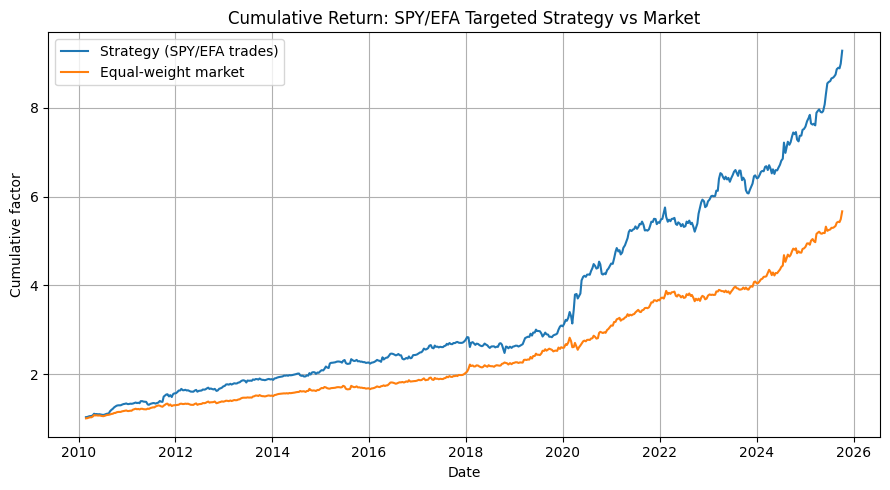

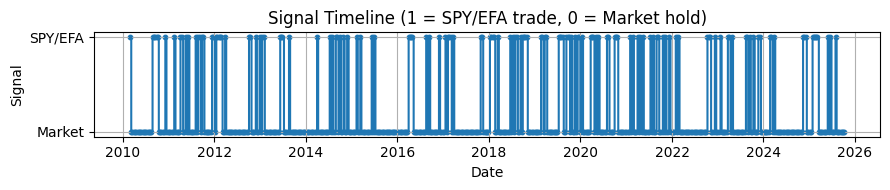

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv('macro_instruments.csv', parse_dates=['Date']).set_index('Date')

# If these columns aren't present, ignore the drop
to_drop = ['XLY_XLP', 'LQD_IEF', 'HYG_IEI', 'TIP_IEF']
df = df.drop(columns=[c for c in to_drop if c in df.columns], errors='ignore')

prices = df.copy()
returns = prices.pct_change()

lookback   = 30
hold       = 7           # non-overlapping window length
percentile = 0.3
positive_assets = ['SPY', 'EFA']  # long-only candidates when signalled
# positive_assets = ['LQD', 'TIP']
# positive_assets = ['USO']

def levy_matrix_from_std(std_win: pd.DataFrame) -> pd.DataFrame:
    """
    Vectorized discrete Lévy-area approximation using standardized returns.
    std_win: (T x N) with no NaNs and finite std by column.
    """
    X = std_win.values
    if X.shape[0] < 2 or X.shape[1] < 2:
        return pd.DataFrame(np.zeros((std_win.shape[1], std_win.shape[1])),
                            index=std_win.columns, columns=std_win.columns)
    M1 = X[:-1].T @ X[1:]           # (N x N)
    M  = 0.5 * (M1 - M1.T)          # antisymmetric
    L  = pd.DataFrame(M, index=std_win.columns, columns=std_win.columns)
    np.fill_diagonal(L.values, 0.0)
    return L

def ann_stats_from_blocks(block_rets: np.ndarray, hold: int):
    block_rets = np.asarray(block_rets, dtype=float)
    block_rets = block_rets[~np.isnan(block_rets)]
    if len(block_rets) == 0:
        return np.nan, np.nan, np.nan, np.nan
    # equity at block frequency
    eq = np.cumprod(1.0 + block_rets)
    # geometric annualized return from equity
    years = (len(block_rets) * hold) / 252.0
    ann_ret = eq[-1]**(1/years) - 1
    # annualized vol from block returns
    block_vol = block_rets.std(ddof=1)
    ann_vol = block_vol * np.sqrt(252.0 / hold)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    # max drawdown on block equity
    run_max = np.maximum.accumulate(eq)
    mdd = (eq / run_max - 1.0).min()
    return ann_ret, ann_vol, sharpe, mdd

# --------------------------
# Walk forward (no lookahead)
# --------------------------
signal_flags   = []  # 1 = trade SPY/EFA basket, 0 = hold market
trade_returns  = []  # k-day compounded strategy return per block
market_returns = []  # k-day compounded equal-weight market per block
trade_dates    = []

t = lookback
while t + hold <= len(returns):
    # Window of raw returns for standardization; drop assets with any NaNs in the window
    win_raw = returns.iloc[t - lookback:t].dropna(axis=1, how='any')
    # Also drop columns with near-zero stdev to avoid divide-by-zero
    stdev = win_raw.std()
    win_raw = win_raw.loc[:, stdev > 0]

    # If too few assets remain, skip this block
    if win_raw.shape[1] < 2:
        t += hold
        continue

    # Standardize and build Lévy matrix
    win_std = (win_raw - win_raw.mean()) / win_raw.std()
    L = levy_matrix_from_std(win_std)

    # Keep only positive entries (direction retained) and row-sum for scores
    Spos = L.clip(lower=0.0)
    scores = Spos.sum(axis=1) # Series indexed by window asset names

    # Leaders/followers counts *for this window*
    m_win = len(scores)
    n_follow = max(1, int(np.floor(percentile * m_win)))
    n_lead   = max(1, int(np.floor(percentile * m_win)))

    # Identify by *names* (not positions)
    follower_assets = scores.nsmallest(n_follow).index.tolist()
    leader_assets   = scores.nlargest(n_lead).index.tolist()

    # Leader signal at day t (raw returns)
    # Use the same *asset names* chosen above
    day_t = returns.index[t]
    leader_ret = returns.loc[day_t, leader_assets].mean(skipna=True)

    # Decision: SPY/EFA only if (signal > 0) AND (present among followers for this window)
    pos_followers = [a for a in positive_assets if a in follower_assets]

    slab = returns.iloc[t + 1: t + 1 + hold]      # (t, t+hold]
    if leader_ret > 0 and len(pos_followers) > 0:
        signal_flags.append(1)
        # Long EW of present SPY/EFA each day (skip NAs day-by-day)
        # If both absent on a day (rare), fallback to market for that day
        fol = slab[pos_followers]
        daily_strat = fol.mean(axis=1, skipna=True)
        # if a day has all-NaN for the basket, replace with market that day
        daily_mkt = slab.mean(axis=1, skipna=True)
        daily_strat = daily_strat.fillna(daily_mkt)
        strat_ret = (1.0 + daily_strat).prod() - 1.0
    else:
        signal_flags.append(0)
        # Hold equal-weight market
        daily_mkt = slab.mean(axis=1, skipna=True)
        strat_ret = (1.0 + daily_mkt).prod() - 1.0

    # Baseline market return for comparison (same slab)
    market_ret = (1.0 + slab.mean(axis=1, skipna=True)).prod() - 1.0

    trade_returns.append(strat_ret)
    market_returns.append(market_ret)
    trade_dates.append(day_t)

    t += hold  # next non-overlapping block

trade_returns  = np.asarray(trade_returns, dtype=float)
market_returns = np.asarray(market_returns, dtype=float)
signal_flags   = np.asarray(signal_flags, dtype=int)
trade_dates    = np.asarray(trade_dates)

num_trades = len(trade_returns)
num_signal = int(signal_flags.sum())
num_market = num_trades - num_signal
signal_pct = num_signal / max(1, num_trades)

win_rate = float(np.mean(trade_returns[signal_flags == 1] > 0)) if num_signal > 0 else np.nan
outperf_rate = float(np.mean(trade_returns[signal_flags == 1] > market_returns[signal_flags == 1])) if num_signal > 0 else np.nan

ann_ret, ann_vol, sharpe, max_dd = ann_stats_from_blocks(trade_returns, hold=hold)

print(f"Total trades: {num_trades}")
print(f"Signal trades (SPY/EFA): {num_signal} ({signal_pct:.2%})")
print(f"Market trades: {num_market}")
print(f"Win rate of signal trades: {win_rate:.2%}" if num_signal > 0 else "Win rate of signal trades: n/a")
print(f"Signal trades outperform market: {outperf_rate:.2%}" if num_signal > 0 else "Signal trades outperform market: n/a")
print(f"Annualised return: {ann_ret:.2%}")
print(f"Annualised volatility: {ann_vol:.2%}")
print(f"Sharpe ratio: {sharpe:.2f}")
print(f"Max drawdown: {max_dd:.2%}")

# Equity curves (block frequency)
eq_strat  = np.cumprod(1.0 + trade_returns)
eq_market = np.cumprod(1.0 + market_returns)

plt.figure(figsize=(9, 5))
plt.plot(trade_dates, eq_strat,  label="Strategy (SPY/EFA trades)")
plt.plot(trade_dates, eq_market, label="Equal-weight market")
plt.title("Cumulative Return: SPY/EFA Targeted Strategy vs Market")
plt.xlabel("Date"); plt.ylabel("Cumulative factor")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(9, 2))
plt.step(trade_dates, signal_flags, where='post')
plt.scatter(trade_dates, signal_flags, s=10)
plt.yticks([0, 1], ["Market", "SPY/EFA"])
plt.title("Signal Timeline (1 = SPY/EFA trade, 0 = Market hold)")
plt.xlabel("Date"); plt.ylabel("Signal")
plt.grid(True); plt.tight_layout(); plt.show()


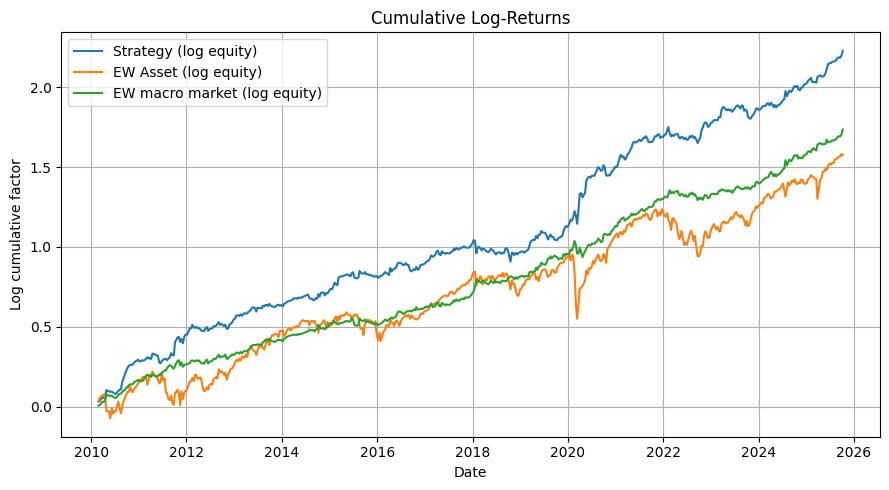

In [ ]:
def plot_cum_log_returns(trade_dates, trade_returns, market_returns, returns, hold, positive_assets):

    trade_returns  = np.asarray(trade_returns, dtype=float)
    market_returns = np.asarray(market_returns, dtype=float)
    trade_dates    = np.asarray(trade_dates)

    # --- strategy & macro market equity (block frequency) ---
    eq_strat  = np.cumprod(1.0 + trade_returns)
    eq_market = np.cumprod(1.0 + market_returns)

    # --- build EW SPY/EFA benchmark at the same block boundaries ---
    bench_returns = []
    for dt in trade_dates:
        # index of the decision day
        t = returns.index.get_loc(dt)
        # slab (t, t+hold]
        slab = returns.iloc[t + 1:t + 1 + hold]
        # daily equal-weight macro (fallback if SPY/EFA missing)
        daily_mkt = slab.mean(axis=1, skipna=True)
        # EW SPY/EFA, if present
        bench_cols = [c for c in positive_assets if c in slab.columns]
        if bench_cols:
            daily_bench = slab[bench_cols].mean(axis=1, skipna=True)
            # if both SPY/EFA are NaN on a day, fall back to macro that day
            daily_bench = daily_bench.fillna(daily_mkt)
            bench_ret = (1.0 + daily_bench).prod() - 1.0
        else:
            bench_ret = (1.0 + daily_mkt).prod() - 1.0

        bench_returns.append(bench_ret)

    bench_returns = np.asarray(bench_returns, dtype=float)
    eq_bench = np.cumprod(1.0 + bench_returns)


    log_eq_strat  = np.log(eq_strat)
    log_eq_bench  = np.log(eq_bench)
    log_eq_market = np.log(eq_market)
    plt.figure(figsize=(9, 5))
    plt.plot(trade_dates, log_eq_strat,  label="Strategy (log equity)")
    plt.plot(trade_dates, log_eq_bench,  label="EW Asset (log equity)")
    plt.plot(trade_dates, log_eq_market, label="EW macro market (log equity)")
    plt.title("Cumulative Log-Returns")
    plt.xlabel("Date")
    plt.ylabel("Log cumulative factor")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_cum_log_returns(trade_dates, trade_returns, market_returns, returns, hold, positive_assets)


In [ ]:
def build_signal_dataframe(returns,
                           lookback: int,
                           hold: int,
                           percentile: float,
                           positive_assets,
                           excel_path: str = None) -> pd.DataFrame:
    """
    Re-run the Lévy leader/follower logic and build a block-frequency
    signal + forward-returns DataFrame for SPY/EFA.

    Returns a DataFrame indexed by decision date with columns:
      - signal_flag        : 1 if we trade SPY/EFA basket, 0 if we hold macro market
      - leader_ret         : cross-sectional leader return at decision date
      - w_SPY, w_EFA       : weights in SPY/EFA (0 when not in the basket)
      - fwd_ret_SPY        : SPY block return over (t, t+hold]
      - fwd_ret_EFA        : EFA block return over (t, t+hold]
      - fwd_ret_market     : equal-weight macro basket block return
      - fwd_ret_strategy   : strategy block return (matches your trade_returns)

    If excel_path is provided, the DataFrame is written to that .xlsx file.
    """

    out_dates = []
    signal_flags = []
    leader_rets = []
    w_spy_list = []
    w_efa_list = []
    fwd_ret_spy_list = []
    fwd_ret_efa_list = []
    fwd_ret_mkt_list = []
    fwd_ret_strat_list = []

    t = lookback
    while t + hold <= len(returns):
        # same window logic as main loop
        win_raw = returns.iloc[t - lookback:t].dropna(axis=1, how='any')
        stdev = win_raw.std()
        win_raw = win_raw.loc[:, stdev > 0]

        if win_raw.shape[1] < 2:
            t += hold
            continue

        # Lévy matrix and scores
        win_std = (win_raw - win_raw.mean()) / win_raw.std()
        L = levy_matrix_from_std(win_std)

        Spos = L.clip(lower=0.0)
        scores = Spos.sum(axis=1)

        m_win = len(scores)
        n_follow = max(1, int(np.floor(percentile * m_win)))
        n_lead   = max(1, int(np.floor(percentile * m_win)))

        follower_assets = scores.nsmallest(n_follow).index.tolist()
        leader_assets   = scores.nlargest(n_lead).index.tolist()

        day_t = returns.index[t]
        leader_ret = returns.loc[day_t, leader_assets].mean(skipna=True)

        pos_followers = [a for a in positive_assets if a in follower_assets]

        slab = returns.iloc[t + 1:t + 1 + hold]
        daily_mkt = slab.mean(axis=1, skipna=True)

        # Forward block returns for SPY/EFA individually
        if 'SPY' in slab.columns:
            fwd_spy = (1.0 + slab['SPY']).prod() - 1.0
        else:
            fwd_spy = np.nan
        if 'EFA' in slab.columns:
            fwd_efa = (1.0 + slab['EFA']).prod() - 1.0
        else:
            fwd_efa = np.nan

        # Strategy logic, identical to your main loop
        if leader_ret > 0 and len(pos_followers) > 0:
            flag = 1
            w_spy = 1.0 / len(pos_followers) if 'SPY' in pos_followers else 0.0
            w_efa = 1.0 / len(pos_followers) if 'EFA' in pos_followers else 0.0

            fol = slab[pos_followers]
            daily_strat = fol.mean(axis=1, skipna=True)
            daily_strat = daily_strat.fillna(daily_mkt)
            strat_ret = (1.0 + daily_strat).prod() - 1.0
        else:
            flag = 0
            w_spy = 0.0
            w_efa = 0.0
            strat_ret = (1.0 + daily_mkt).prod() - 1.0

        market_ret = (1.0 + daily_mkt).prod() - 1.0

        out_dates.append(day_t)
        signal_flags.append(flag)
        leader_rets.append(leader_ret)
        w_spy_list.append(w_spy)
        w_efa_list.append(w_efa)
        fwd_ret_spy_list.append(fwd_spy)
        fwd_ret_efa_list.append(fwd_efa)
        fwd_ret_mkt_list.append(market_ret)
        fwd_ret_strat_list.append(strat_ret)

        t += hold

    idx = pd.Index(out_dates, name="Date")
    signal_df = pd.DataFrame(
        {
            "signal_flag": signal_flags,
            "leader_ret": leader_rets,
            "w_SPY": w_spy_list,
            "w_EFA": w_efa_list,
            "fwd_ret_SPY": fwd_ret_spy_list,
            "fwd_ret_EFA": fwd_ret_efa_list,
            "fwd_ret_market": fwd_ret_mkt_list,
            "fwd_ret_strategy": fwd_ret_strat_list,
        },
        index=idx,
    )

    if excel_path is not None:
        signal_df.to_excel(excel_path)

    return signal_df

signal_df = build_signal_dataframe(
    returns=returns,
    lookback=lookback,
    hold=hold,
    percentile=percentile,
    positive_assets=positive_assets,
    excel_path="spy_efa_signals.xlsx",  # or any path you like
)



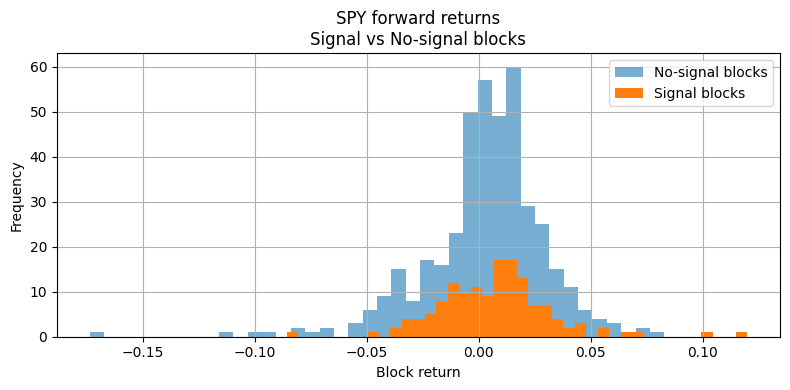

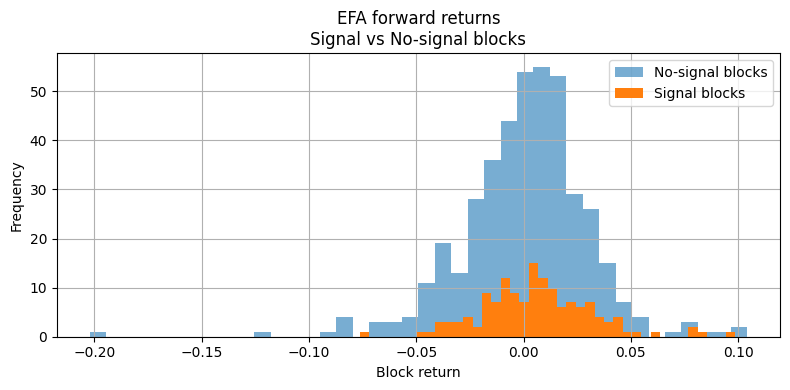

,n_signal,n_nosignal,mean_signal,mean_nosignal,t_mean,p_mean,winrate_signal,winrate_nosignal,z_pos,p_pos
asset,,,,,,,,,,
SPY,143,419,0.007117,0.003015,1.622813,0.104629,0.615385,0.610979,0.093366,0.925613
EFA,143,419,0.006330,0.000922,2.044452,0.040909,0.594406,0.560859,0.699530,0.484221


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import erf, sqrt

# ---- helpers for simple tests (no SciPy needed) ----

def _normal_cdf(x: float) -> float:
    return 0.5 * (1.0 + erf(x / sqrt(2.0)))

def _diff_in_means_test(x_sig: pd.Series, x_nosig: pd.Series):
    """
    Welch-style difference in means, using normal approximation.
    Returns (mean_signal, mean_nosignal, t_stat, p_value_two_sided).
    """
    x_sig = x_sig.dropna()
    x_nosig = x_nosig.dropna()

    n1, n2 = len(x_sig), len(x_nosig)
    m1, m2 = x_sig.mean(), x_nosig.mean()
    v1, v2 = x_sig.var(ddof=1), x_nosig.var(ddof=1)

    se = np.sqrt(v1 / n1 + v2 / n2)
    t_stat = (m1 - m2) / se if se > 0 else 0.0
    p_val = 2.0 * (1.0 - _normal_cdf(abs(t_stat)))
    return m1, m2, t_stat, p_val

def _prop_test(pos1: int, n1: int, pos2: int, n2: int):
    """
    Two-proportion z-test for difference in positivity rates.
    Returns (p1, p2, z_stat, p_value_two_sided).
    """
    p1 = pos1 / n1
    p2 = pos2 / n2
    p_pool = (pos1 + pos2) / (n1 + n2)
    se = np.sqrt(p_pool * (1.0 - p_pool) * (1.0 / n1 + 1.0 / n2))
    z_stat = (p1 - p2) / se if se > 0 else 0.0
    p_val = 2.0 * (1.0 - _normal_cdf(abs(z_stat)))
    return p1, p2, z_stat, p_val

# ---- main analysis function ----

def analyze_signal_distributions(
    excel_path: str,
    asset_cols=("fwd_ret_SPY", "fwd_ret_EFA"),
    signal_col: str = "signal_flag",
    bins: int = 40,
) -> pd.DataFrame:

    df = pd.read_excel(excel_path, index_col=0, parse_dates=True)

    rows = []

    for asset_col in asset_cols:
        # split into signal / no-signal blocks
        x_sig = df.loc[df[signal_col] == 1, asset_col].dropna()
        x_nosig = df.loc[df[signal_col] == 0, asset_col].dropna()

        # ----- distribution plots -----
        plt.figure(figsize=(8, 4))
        plt.hist(x_nosig, bins=bins, alpha=0.6, label="No-signal blocks")
        plt.hist(x_sig, bins=bins, alpha=1, label="Signal blocks")
        pretty_name = asset_col.replace("fwd_ret_", "")
        plt.title(f"{pretty_name} forward returns\nSignal vs No-signal blocks")
        plt.xlabel("Block return")
        plt.ylabel("Frequency")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # ----- mean-return test -----
        mean_sig, mean_nosig, t_stat, p_mean = _diff_in_means_test(x_sig, x_nosig)

        # ----- positivity test -----
        pos_sig = (x_sig > 0).sum()
        pos_nosig = (x_nosig > 0).sum()
        p_sig, p_nosig, z_stat, p_pos = _prop_test(pos_sig, len(x_sig),
                                                   pos_nosig, len(x_nosig))

        rows.append(
            {
                "asset": pretty_name,
                "n_signal": len(x_sig),
                "n_nosignal": len(x_nosig),
                "mean_signal": mean_sig,
                "mean_nosignal": mean_nosig,
                "t_mean": t_stat,
                "p_mean": p_mean,
                "winrate_signal": p_sig,
                "winrate_nosignal": p_nosig,
                "z_pos": z_stat,
                "p_pos": p_pos,
            }
        )

    stats_df = pd.DataFrame(rows).set_index("asset")
    display(stats_df)
    return stats_df

stats_df = analyze_signal_distributions("spy_efa_signals.xlsx")


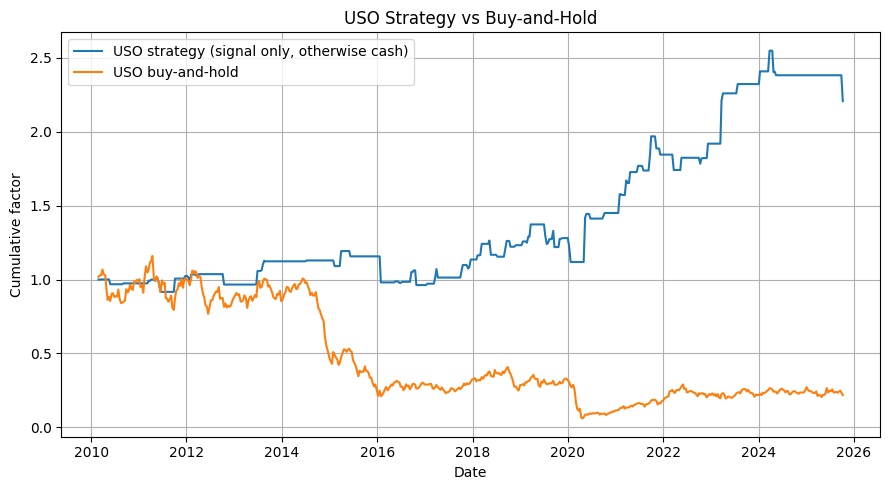

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# assumes df (prices) and returns already defined
df = pd.read_csv('macro_instruments.csv', parse_dates=['Date']).set_index('Date')
returns = df.pct_change()
lookback   = 30
hold       = 7
percentile = 0.3

def levy_matrix_from_std(std_win: pd.DataFrame) -> pd.DataFrame:
    X = std_win.values
    if X.shape[0] < 2 or X.shape[1] < 2:
        return pd.DataFrame(np.zeros((std_win.shape[1], std_win.shape[1])),
                            index=std_win.columns, columns=std_win.columns)
    M1 = X[:-1].T @ X[1:]
    M  = 0.5 * (M1 - M1.T)
    L  = pd.DataFrame(M, index=std_win.columns, columns=std_win.columns)
    np.fill_diagonal(L.values, 0.0)
    return L

positive_assets = ["USO"]

signal_flags = []
block_rets_strat = []
block_rets_uso = []
block_dates = []

t = lookback
while t + hold <= len(returns):
    # same window logic as before
    win_raw = returns.iloc[t - lookback:t].dropna(axis=1, how='any')
    stdev   = win_raw.std()
    win_raw = win_raw.loc[:, stdev > 0]

    if win_raw.shape[1] < 2:
        t += hold
        continue

    win_std = (win_raw - win_raw.mean()) / win_raw.std()
    L       = levy_matrix_from_std(win_std)

    Spos   = L.clip(lower=0.0)
    scores = Spos.sum(axis=1)

    m_win   = len(scores)
    n_follow = max(1, int(np.floor(percentile * m_win)))
    n_lead   = max(1, int(np.floor(percentile * m_win)))

    follower_assets = scores.nsmallest(n_follow).index.tolist()
    leader_assets   = scores.nlargest(n_lead).index.tolist()

    day_t     = returns.index[t]
    leader_ret = returns.loc[day_t, leader_assets].mean(skipna=True)

    pos_followers = [a for a in positive_assets if a in follower_assets]

    slab = returns.iloc[t + 1:t + 1 + hold]   # (t, t+hold]

    # USO block return
    if "USO" in slab.columns and not slab["USO"].isna().all():
        fwd_uso = (1.0 + slab["USO"].dropna()).prod() - 1.0
    else:
        fwd_uso = 0.0

    # Strategy: if signal, take USO; else stay flat
    if leader_ret > 0 and len(pos_followers) > 0:
        flag = 1
        strat_ret = fwd_uso
    else:
        flag = 0
        strat_ret = 0.0

    signal_flags.append(flag)
    block_rets_strat.append(strat_ret)
    block_rets_uso.append(fwd_uso)
    block_dates.append(day_t)

    t += hold

block_rets_strat = np.asarray(block_rets_strat, float)
block_rets_uso   = np.asarray(block_rets_uso, float)
block_dates      = np.asarray(block_dates)

eq_strat = np.cumprod(1.0 + block_rets_strat)
eq_uso   = np.cumprod(1.0 + block_rets_uso)

plt.figure(figsize=(9, 5))
plt.plot(block_dates, eq_strat, label="USO strategy (signal only, otherwise cash)")
plt.plot(block_dates, eq_uso,   label="USO buy-and-hold")
plt.title("USO Strategy vs Buy-and-Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative factor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


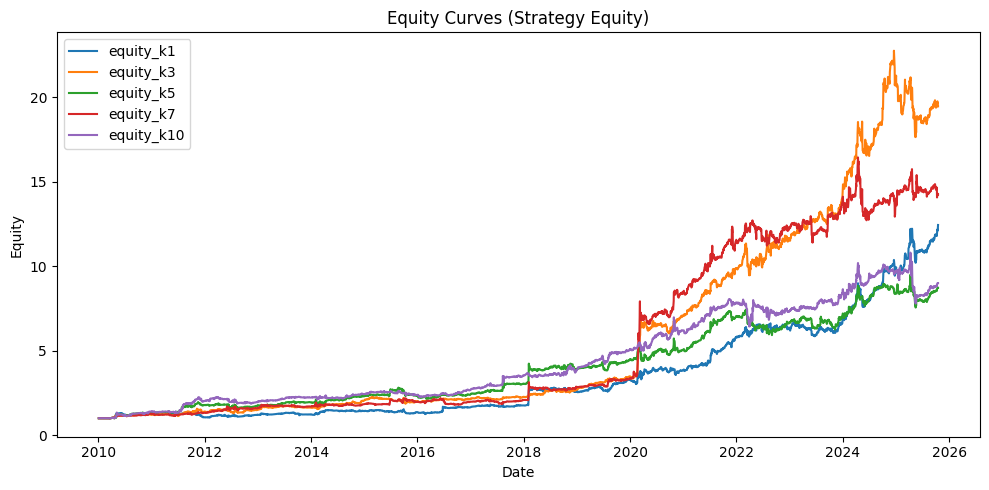

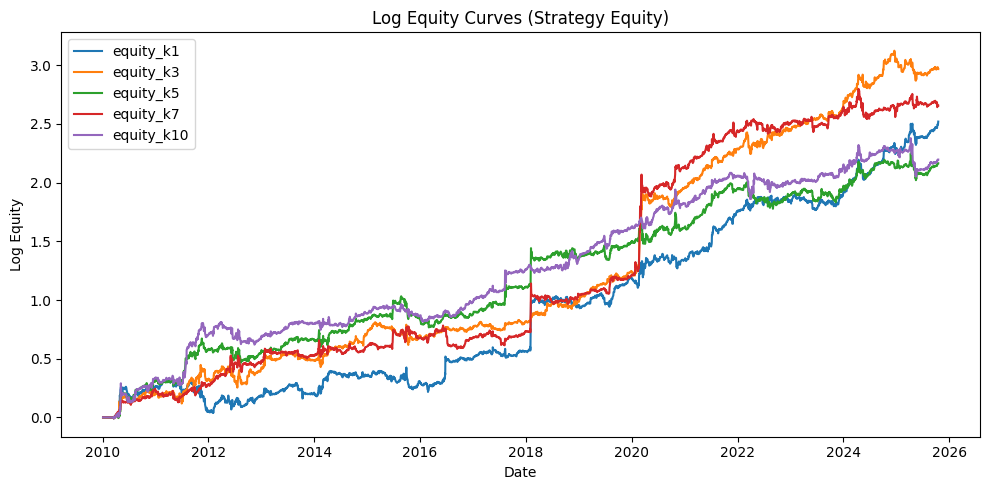

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the uploaded equity file
path = "long_leg_only_equities_k_5_7_10.csv"
df = pd.read_csv(path)

# Convert Date to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Plot equity curves
plt.figure(figsize=(10, 5))
for col in df.columns:
    if col.startswith('equity_'):
        plt.plot(df.index, df[col], label=col)
plt.xlabel('Date')
plt.ylabel('Equity')
plt.title('Equity Curves (Strategy Equity)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot log equity curves
import numpy as np

plt.figure(figsize=(10, 5))
for col in df.columns:
    if col.startswith('equity_'):
        log_equity = np.log(df[col].replace(0, float('nan')))
        plt.plot(df.index, log_equity, label=col)
plt.xlabel('Date')
plt.ylabel('Log Equity')
plt.title('Log Equity Curves (Strategy Equity)')
plt.legend()
plt.tight_layout()
plt.show()

